In [20]:
import tensorflow as tf
import utils as u
import h5py
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import os
import numpy as np

from sklearn.metrics import roc_curve,roc_auc_score
from sklearn.model_selection import train_test_split,cross_val_score
from sklearn import metrics
from sklearn.multiclass import OneVsRestClassifier
%matplotlib inline
import itertools

import keras
from keras.callbacks import ModelCheckpoint,EarlyStopping
from keras import backend as K
from keras.layers import Dense, Dropout, Flatten,Conv2D, MaxPooling2D,Activation,BatchNormalization,LeakyReLU
from keras.utils import to_categorical
from keras.models import Sequential
from keras.optimizers import Adam

In [2]:
data_folder = '../data'
file_name = 'HCAL_digi+rechit_occ.hdf5'
group = 'DigiTask_Occupancy_depth_depth1'

input_file=h5py.File(data_folder+"/"+file_name,'r+')

data_sample= np.array(input_file[group])


print data_sample.shape

data_sample=data_sample[:,:,26:58]

print data_sample.shape

(999, 72, 84)
(999, 72, 32)


Shape of regular image is:  (999, 72, 32)
Shape of dead image is:  (999, 72, 32)
Shape of hot image is:  (999, 72, 32)
Shape of random image is:  (0,)

max of image is:  1819.0



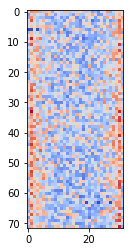

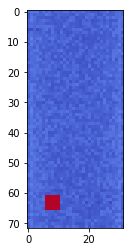

In [3]:
input_images=data_sample[:]
hotregion_image=[]
deadregion_image=[]
random_image=[]
count=0
for k in input_images:
    a=np.random.randint(input_images.shape[2]-5)
    b=np.random.randint(input_images.shape[1]-5)
    #a=15
    #b=15
    xdim=(a,a+5)
    ydim=(b,b+5)
   
    hotregion_image.append( u.hotregion(k,xdim,ydim))
    deadregion_image.append(u.killregion(k,xdim,ydim))
    #random_image.append(u.randomregion(k,xdim,ydim))
    #print "xdim,ydim:",xdim,ydim
    #print count
    count+=1
    
    
hotregion_image=np.array(hotregion_image)
deadregion_image=np.array(deadregion_image)
random_image=np.array(random_image)
#print "xdim,ydim",xdim,ydim
print "Shape of regular image is: ",input_images.shape
print "Shape of dead image is: " ,deadregion_image.shape
print "Shape of hot image is: " ,hotregion_image.shape
print "Shape of random image is: " ,random_image.shape

print '\nmax of image is: ' ,np.max(input_images)
print ''
im=plt.imshow(input_images[1],cmap=cm.coolwarm)
plt.show()
plt.clf()


#im=plt.imshow(random_image[1],cmap=cm.coolwarm)
#plt.show()
#plt.clf()
#
im=plt.imshow(hotregion_image[1],cmap=cm.coolwarm)
plt.show()
plt.clf()#plt.clf clears the figure and it's axis but leaves the window open. 
         #as opposed to plt.close which closes the window. If you are showing many images at a time without
         #closing the window it is better.

#im=plt.imshow(deadregion_image[1],cmap=cm.coolwarm)
#plt.show()
#plt.clf()
#input_image=np.reshape(input_image,(input_image.shape[0],input_image.shape[1]))


If you want to see the group of images

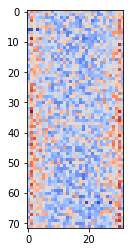

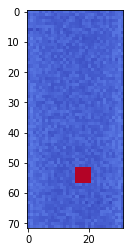

-----------------


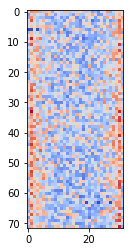

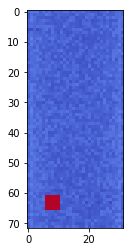

-----------------


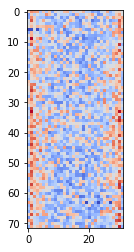

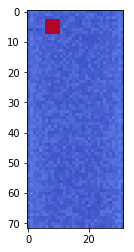

-----------------


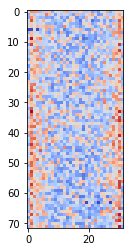

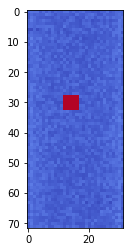

-----------------


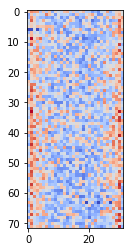

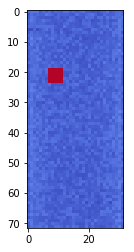

-----------------


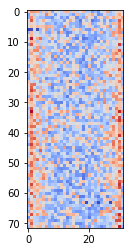

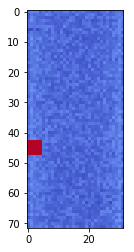

-----------------


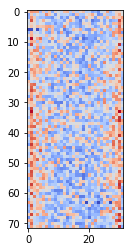

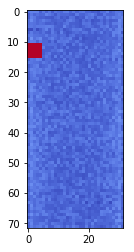

-----------------


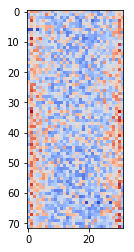

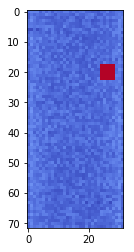

-----------------


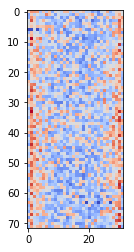

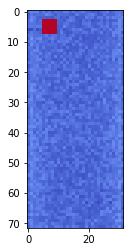

-----------------


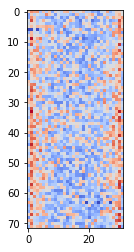

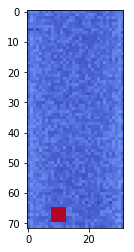

-----------------


In [4]:
for k in range(10):
    im=plt.imshow(input_images[k],cmap=cm.coolwarm)
    plt.show()
    plt.clf()

    #im=plt.imshow(random_image[k],cmap=cm.coolwarm)
    #plt.show()
    #plt.clf()
    #
    im=plt.imshow(hotregion_image[k],cmap=cm.coolwarm)
    plt.show()
    plt.clf()#plt.clf clears the figure and it's axis but leaves the window open. 
             #as opposed to plt.close which closes the window. If you are showing many images at a time without
             #closing the window it is better.
    
    #im=plt.imshow(deadregion_image[k],cmap=cm.coolwarm)
    #plt.show()
    #plt.clf()
    print '-----------------'


In [5]:
sample= np.append(data_sample,hotregion_image,axis=0)
sample= np.append(sample,deadregion_image,axis=0)
#sample= np.append(sample,random_image,axis=0)            


print sample.shape

(2997, 72, 32)


create the corresponding label matrices

This line of code below was used when the reshping of the images was needed. Now we use a CNN so we don't need to 

For CNN

In [6]:
X=np.copy(sample)

y=np.zeros((sample.shape[0],1))


In [7]:
#this is because I am only going to add the hot and dead region images

for i in range(2,0,-1):
    y[-i*input_images.shape[0]:]=3-i
#if you want it as intergers leave this as it is
#if you would like it as a vector then do this
y=to_categorical(y,3)
#print 'First few labels are \n',y[:5]
#print y.shape
#print 'Labels from 1 class to another are like this\n',y[998:1004]
#print 'Labels from 1 class to another are like this\n',y[1997:2004]


In [8]:
# convert class vectors to binary class matrices
#y_train = keras.utils.to_categorical(y_train, num_classes)
#y_test = keras.utils.to_categorical(y_test, num_classes)

print "X shape is: ",X.shape
print "y shape is: ",y.shape
# input image dimensions
img_rows, img_cols = X.shape[1],X.shape[2]

X shape is:  (2997, 72, 32)
y shape is:  (2997, 3)


Xtrain.shape (1798, 72, 32)
Xtest.shape (1199, 72, 32)
ytrain.shape (1798, 3)
ytest.shape (1199, 3)
Printing labels and their corresponding images
-------------------
[ 0.  1.  0.]


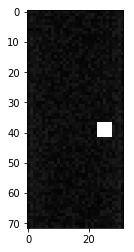

-------------------
[ 0.  1.  0.]


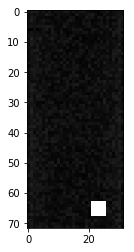

-------------------
[ 1.  0.  0.]


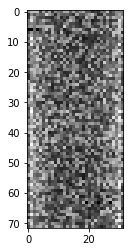

-------------------
[ 0.  1.  0.]


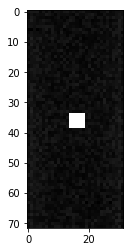

-------------------
[ 1.  0.  0.]


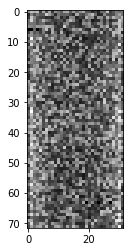

-------------------
[ 1.  0.  0.]


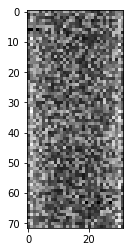

-------------------
[ 1.  0.  0.]


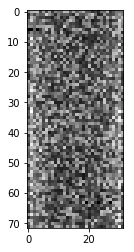

-------------------
[ 0.  0.  1.]


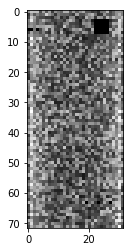

-------------------
[ 0.  1.  0.]


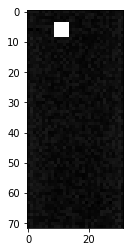

-------------------
[ 0.  1.  0.]


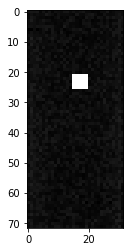

Xtrain.shape after if statement (1798, 72, 32, 1)
Xtest.shape after if statement (1199, 72, 32, 1)
ytrain.shape after if statement (1798, 3)
ytest.shape after if statement (1199, 3)


In [9]:

Xtrain, Xtest ,ytrain, ytest =train_test_split(X,y,test_size=.4,random_state =5 )

print 'Xtrain.shape',Xtrain.shape
print 'Xtest.shape',Xtest.shape
print 'ytrain.shape',ytrain.shape
print 'ytest.shape',ytest.shape
print 'Printing labels and their corresponding images'
    
for k in range(10):
    print'-------------------'
    print ytrain[k]
    im=plt.imshow(Xtrain[k],cmap=cm.gray)
    plt.show()
    plt.clf()


Xtrain, Xtest,input_shape= u.check_test_and_train_images_format(Xtrain, Xtest, img_rows, img_cols)

print 'Xtrain.shape after if statement',Xtrain.shape
print 'Xtest.shape after if statement',Xtest.shape
print 'ytrain.shape after if statement',ytrain.shape
print 'ytest.shape after if statement',ytest.shape
    


# Creating and training the model

In [10]:
# this is the dummy model
model = Sequential([
BatchNormalization(input_shape=input_shape),
Conv2D(8, kernel_size=(3, 3), strides=(2, 2), activation='relu'),
Conv2D(8, kernel_size=(3, 3), strides=(2, 2), activation='relu'),

Dropout(0.25),

Flatten(),

Dense(3, activation='softmax')
    
])
model.compile(loss='categorical_crossentropy',
              optimizer=Adam(lr=5e-4),
              metrics=['accuracy'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization_1 (Batch (None, 72, 32, 1)         4         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 35, 15, 8)         80        
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 17, 7, 8)          584       
_________________________________________________________________
dropout_1 (Dropout)          (None, 17, 7, 8)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 952)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 2859      
Total params: 3,527
Trainable params: 3,525
Non-trainable params: 2
_________________________________________________________________


In [11]:
checkpointer = ModelCheckpoint(filepath='best_weights.hdf5', verbose=4, save_best_only=True)
earlystop= EarlyStopping(monitor='val_loss', min_delta=0, patience=5, verbose=4, mode='auto')

history = model.fit(Xtrain,ytrain,epochs=150
                    ,verbose=2
                    ,validation_data=(Xtest,ytest)
                    ,shuffle=True
                    ,callbacks=[checkpointer,earlystop])

Train on 1798 samples, validate on 1199 samples
Epoch 1/150
Epoch 00001: val_loss improved from inf to 1.05525, saving model to best_weights.hdf5
 - 2s - loss: 1.0890 - acc: 0.3776 - val_loss: 1.0552 - val_acc: 0.2902
Epoch 2/150
Epoch 00002: val_loss improved from 1.05525 to 0.96832, saving model to best_weights.hdf5
 - 1s - loss: 1.0067 - acc: 0.4227 - val_loss: 0.9683 - val_acc: 0.3987
Epoch 3/150
Epoch 00003: val_loss improved from 0.96832 to 0.75605, saving model to best_weights.hdf5
 - 1s - loss: 0.8106 - acc: 0.5890 - val_loss: 0.7560 - val_acc: 0.6455
Epoch 4/150
Epoch 00004: val_loss improved from 0.75605 to 0.59040, saving model to best_weights.hdf5
 - 1s - loss: 0.6343 - acc: 0.6313 - val_loss: 0.5904 - val_acc: 0.6047
Epoch 5/150
Epoch 00005: val_loss improved from 0.59040 to 0.52632, saving model to best_weights.hdf5
 - 1s - loss: 0.5611 - acc: 0.6513 - val_loss: 0.5263 - val_acc: 0.6430
Epoch 6/150
Epoch 00006: val_loss improved from 0.52632 to 0.49396, saving model to be

Epoch 52/150
Epoch 00052: val_loss improved from 0.36930 to 0.35735, saving model to best_weights.hdf5
 - 1s - loss: 0.3646 - acc: 0.8571 - val_loss: 0.3573 - val_acc: 0.8949
Epoch 53/150
Epoch 00053: val_loss improved from 0.35735 to 0.35465, saving model to best_weights.hdf5
 - 1s - loss: 0.3608 - acc: 0.8610 - val_loss: 0.3546 - val_acc: 0.9349
Epoch 54/150
Epoch 00054: val_loss did not improve
 - 1s - loss: 0.3614 - acc: 0.8526 - val_loss: 0.3578 - val_acc: 0.8432
Epoch 55/150
Epoch 00055: val_loss improved from 0.35465 to 0.34537, saving model to best_weights.hdf5
 - 1s - loss: 0.3464 - acc: 0.8704 - val_loss: 0.3454 - val_acc: 0.9166
Epoch 56/150
Epoch 00056: val_loss did not improve
 - 1s - loss: 0.3400 - acc: 0.8743 - val_loss: 0.3455 - val_acc: 0.8666
Epoch 57/150
Epoch 00057: val_loss improved from 0.34537 to 0.32521, saving model to best_weights.hdf5
 - 1s - loss: 0.3290 - acc: 0.8799 - val_loss: 0.3252 - val_acc: 0.9383
Epoch 58/150
Epoch 00058: val_loss improved from 0.325

Epoch 104/150
Epoch 00104: val_loss did not improve
 - 1s - loss: 0.1031 - acc: 0.9705 - val_loss: 0.1037 - val_acc: 0.9575
Epoch 105/150
Epoch 00105: val_loss improved from 0.08901 to 0.08637, saving model to best_weights.hdf5
 - 1s - loss: 0.1108 - acc: 0.9666 - val_loss: 0.0864 - val_acc: 0.9858
Epoch 106/150
Epoch 00106: val_loss did not improve
 - 1s - loss: 0.0993 - acc: 0.9739 - val_loss: 0.0872 - val_acc: 0.9691
Epoch 107/150
Epoch 00107: val_loss improved from 0.08637 to 0.08245, saving model to best_weights.hdf5
 - 1s - loss: 0.1036 - acc: 0.9689 - val_loss: 0.0825 - val_acc: 0.9766
Epoch 108/150
Epoch 00108: val_loss improved from 0.08245 to 0.08114, saving model to best_weights.hdf5
 - 1s - loss: 0.1019 - acc: 0.9700 - val_loss: 0.0811 - val_acc: 0.9875
Epoch 109/150
Epoch 00109: val_loss improved from 0.08114 to 0.07627, saving model to best_weights.hdf5
 - 1s - loss: 0.1017 - acc: 0.9694 - val_loss: 0.0763 - val_acc: 0.9850
Epoch 110/150
Epoch 00110: val_loss improved fro

In [12]:
len(history.epoch)

146

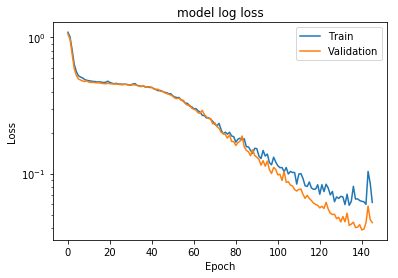

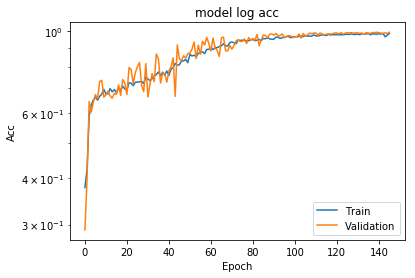

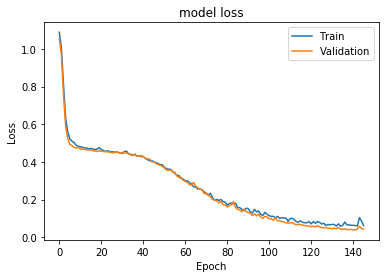

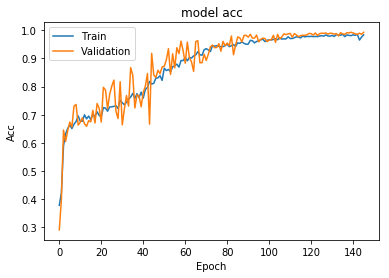

In [13]:
u.plot_loss(history, "model log loss","log")
u.plot_acc(history, "model log acc","log")

u.plot_loss(history, "model loss","linear")
u.plot_acc(history, "model acc","linear")



In [14]:
ypred=model.predict(Xtest)
ypredproba=model.predict_proba(Xtest)
#it's preferable to use .predict_classes because .predict might give probabilities 
#and not the label's in the case of multiclass
ypredclass=model.predict_classes(Xtest)

ypredclass=np.reshape(ypredclass,(ypredclass.shape[0],1))
#use argmax(1) to give the position of max value in a categorical variable like ytest
#it's basically a .predict_classes for ytest
ytestclass= ytest.argmax(1)
ytestclass=np.reshape(ytestclass,(ytestclass.shape[0],1))

In [15]:
np.all(ypredproba==ypred)
#this confirms my suspicions

True

In [16]:
print ytestclass[40:50],'\n\n\n', ypredclass[40:50]

[[0]
 [1]
 [0]
 [0]
 [2]
 [0]
 [1]
 [1]
 [1]
 [2]] 


[[0]
 [1]
 [0]
 [0]
 [2]
 [0]
 [1]
 [1]
 [1]
 [2]]


In [17]:
# from categorial to lable indexing


#yprednotcategorical =ypred.argmax(1)
#print ytestnotcategorical
#print yprednotcategorical
#print metrics.accuracy_score(ytest,ypred)

confusion= metrics.confusion_matrix(ytestclass,ypredclass)


def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    #print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization


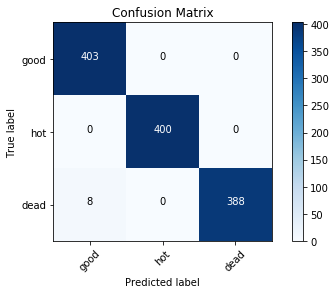

In [18]:
plotlabels=['good','hot','dead']
plot_confusion_matrix(confusion,plotlabels,title='Confusion Matrix')